<a href="https://colab.research.google.com/github/michalis0/DataScience_and_MachineLearning/blob/master/Week_13/lab_session/Week_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install datasets
import datasets
import pandas as pd
import seaborn as sns
import transformers
!pip install shap
import shap
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
!pip install lime
import lime
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt


# Interpretability

So far we have used various models as black boxes, where an input goes in and an output goes out.

Interpretability allows us to understand what happens inside this blackbox.

<img src='https://assets.spe.org/dims4/default/f6b3d58/2147483647/strip/true/crop/696x392+0+0/resize/800x451!/quality/90/?url=http%3A%2F%2Fspe-brightspot.s3.us-east-2.amazonaws.com%2Fae%2F27%2F97e3d6195614a45bed36e7a965e2%2Fblackbox.jpg' width="500">

## Content

The goal of this walkthrough is to introduce explainability modules for Machine Learning models. Those allow us to better retrace the steps taken by the computer.


## Background <a class="anchor" id="Background"></a>

### Objective

AI is often perceived as a black box. This erodes trust and makes it harder for some industries to adopt it.

In order to mitigate this, XAI models (explainable AI) are being developped that allow us to retrace the steps performed by the computer.

### Examples of XAI models
User interface examples:


*   [Language level](http://deeptext.unice.fr/FLE/)
*   [Emotion classification](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html)



Various XAI libraries exist, the two most popular ones being `shap`and `lime`


## Shap


### Example of a sentiment analisys model
Let's start with an example of `shap` over a `Sentiment Analisys` model.

For this example we will use a pretrained bert model, and we will try to identify how each feature affects the final prediction.

In [2]:
%%capture
# load the dataset
dataset = datasets.load_dataset("emotion", split="train")
data = pd.DataFrame({"text": dataset["text"], "emotion": dataset["label"]})

In [3]:
%%capture
# load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "nateraw/bert-base-uncased-emotion", use_fast=True
)

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "nateraw/bert-base-uncased-emotion"
).cuda() # if this step fails, relaunch your google colab with a T4 runtime, ensuring cuda support

# build a pipeline object to do predictions
pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0,
    top_k=None,
)

In [4]:
# build an explainer function that extends our predictions pipeline
shap_explainer = shap.Explainer(pred)

In [5]:
# show the explainer
shap_values = shap_explainer(["I am happy to be following the DSML course, although it is sad it is almost over"])
shap.plots.text(shap_values)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.79s/it]               


### Your turn!

Plot a `shap` barplot that represents the weights of each word in a sentence for different emotions. You can use the documentation available [here](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html).

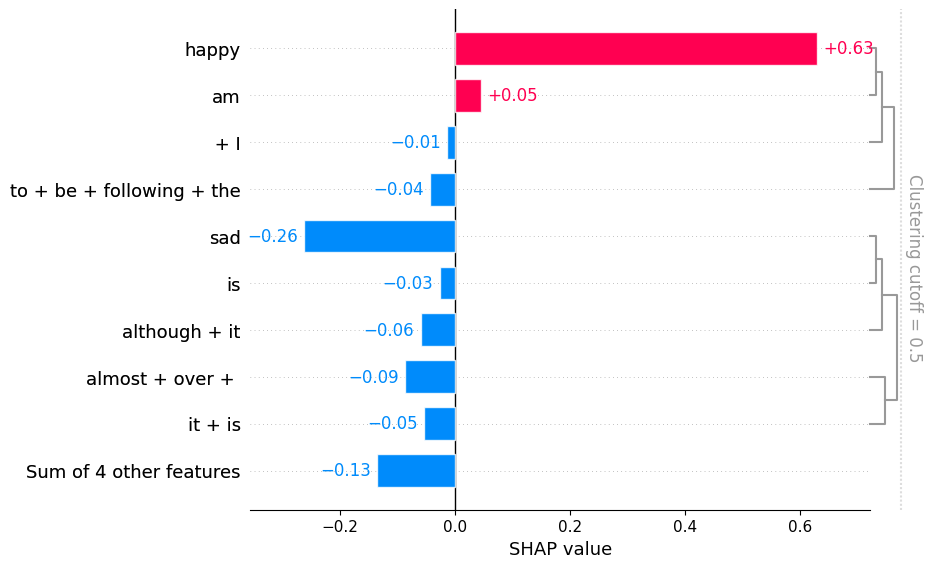

In [6]:
shap.plots.bar(shap_values[:,:,'joy'][0], max_display=10)

## LIME
We will now create a similar model using `lime` explainability over youtube spam classifications. To do so we will train a model on the labeled commets of the videos from PSY, Shakira, LMFAO and Katy Perry, and then predict if some comments are spam or not.



### Classification
We will try to identify bellow the importance of each factor in the computers decision making.

We will apply it on two models, a `Random Forest Classifier` and a `Decision Tree`

In [7]:
psy = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Week_13/lab_session/data/Youtube01-Psy.csv')
perry = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Week_13/lab_session/data/Youtube02-KatyPerry.csv')
LMFAO = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Week_13/lab_session/data/Youtube03-LMFAO.csv')
Eminem = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Week_13/lab_session/data/Youtube04-Eminem.csv')
Shakira = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Week_13/lab_session/data/Youtube05-Shakira.csv')
full_train = pd.concat([psy, perry, LMFAO, Shakira, Eminem]).reset_index().drop(columns = ['index'])

In [8]:
# Load useful libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

X= full_train['CONTENT']
y= full_train['CLASS']


# Using default tokenizer in TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words="english")

# Learn the vocabulary dictionary and return document-term matrix
features = tfidf.fit_transform(X)

# Visualize result in dataframe
X = pd.DataFrame(
    features.todense(),
    columns=tfidf.get_feature_names_out(),
)


# Create Train & Test Data
X_train, X_test, y_train, y_test = train_test_split(X.fillna(0), y,test_size=0.3,
                                                	stratify =y,
                                                	random_state = 13)
# Build the model
rf_clf = RandomForestClassifier(max_features=2, n_estimators =100 ,bootstrap = True)

rf_clf.fit(X_train, y_train)
predict_fn_clf = lambda x: rf_clf.predict_proba(x).astype(float)

# Make prediction on the testing data
y_pred = rf_clf.predict(X_test)

# Classification Report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       312
           1       0.90      0.99      0.95       275

    accuracy                           0.95       587
   macro avg       0.95      0.95      0.95       587
weighted avg       0.95      0.95      0.95       587



In [9]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer

# Get the class names
class_names = ['Not spam', 'Spam']

# Get the feature names
feature_names = list(X_train.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
lime_explainer = LimeTabularExplainer(X_train.values, feature_names =
                                 feature_names,
                                 class_names = class_names,
                                 mode = 'classification')



In [10]:
choosen_instance = X_test.loc[:].values[0]
exp = lime_explainer.explain_instance(choosen_instance, predict_fn_clf,num_features=10)
exp.show_in_notebook(show_all=False)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


### Second example: Logistic regression

For this example we will analyse different tags on Quora posts


In [11]:
wget('https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Week_13/lab_session/data/Quora.csv.zip')
!unzip Quora.csv.zip
train_df = pd.read_csv(r"Quora.csv").dropna()
print("Train shape : ", train_df.shape)

## split to train and val (values to test)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2018)
val_df.reset_index(drop=True)

## vectorize to tf-idf vectors
tfidf_vc = TfidfVectorizer(min_df = 10, max_features = 100000, analyzer = "word", ngram_range = (1, 2), stop_words = 'english', lowercase = True)
train_vc = tfidf_vc.fit_transform(train_df["question_text"])
val_vc = tfidf_vc.transform(val_df["question_text"])

Train shape :  (33171, 3)


In [12]:
## Training our model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C = 0.5, solver = "sag")
model = model.fit(train_vc, train_df.target)
val_pred = model.predict(val_vc)

## checking the accuracy of the model
from sklearn.metrics import accuracy_score
print("accuracy score = {}".format(accuracy_score(val_df.target, val_pred)))



accuracy score = 0.9475587703435805


Predictions and explaining one of the predictions:

Some good examples of divisive questions are indexed at : 15, 163, 226, 240, 306, and 979

In [19]:
from sklearn.pipeline import make_pipeline
idx = val_df.index[306]

c = make_pipeline(tfidf_vc, model)
class_names = ["sincere", "insincere"]
explainer = LimeTextExplainer(class_names = class_names)
exp = explainer.explain_instance(val_df["question_text"][idx], c.predict_proba, num_features = 10)

print("Question: \n", val_df["question_text"][idx])
print("Probability (Insincere) =", c.predict_proba([val_df["question_text"][idx]])[0, 1])
print("Probability (Sincere) =", c.predict_proba([val_df["question_text"][idx]])[0, 0])

Question: 
 Could Obama go to prison if it is determined that he had Trump wiretapped illegally?
Probability (Insincere) = 0.4760165451413484
Probability (Sincere) = 0.5239834548586516


In [20]:
exp.as_list()

[('Trump', 0.344154790239957),
 ('Obama', 0.17042211046756253),
 ('determined', -0.17024077292138934),
 ('prison', -0.03592624442338773),
 ('it', -0.0037143889743879504),
 ('Could', 0.0031851893302920057),
 ('had', -0.002842657797004262),
 ('if', 0.0019320758571669673),
 ('wiretapped', 0.0017351785855591762),
 ('go', 0.0015626618237880182)]

In [21]:
exp.show_in_notebook(text=val_df["question_text"][idx], labels=(1,))

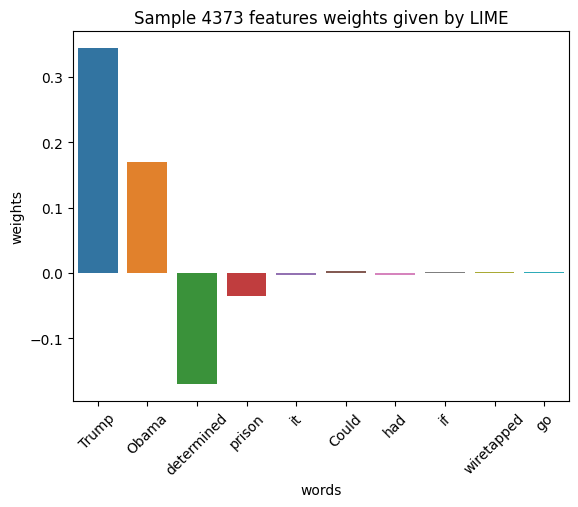

In [22]:
import collections

weights = collections.OrderedDict(exp.as_list())
lime_weights = pd.DataFrame({"words": list(weights.keys()), "weights": list(weights.values())})

sns.barplot(x = "words", y = "weights", data = lime_weights)
plt.xticks(rotation = 45)
plt.title("Sample {} features weights given by LIME".format(idx))
plt.show()

### Your turn!

Build a decision tree classifier and use the sklearn `plot_tree` model to identify the weight of different methods on the final prediction.

Does the logic of the model follow your intuitition?

In [17]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt_clf = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 2)
dt_clf.fit(X_train, y_train)

# Predict on the test data and evaluate the model
y_pred = dt_clf.predict(X_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       345
           1       0.80      1.00      0.89       242

    accuracy                           0.89       587
   macro avg       0.90      0.91      0.89       587
weighted avg       0.91      0.89      0.90       587



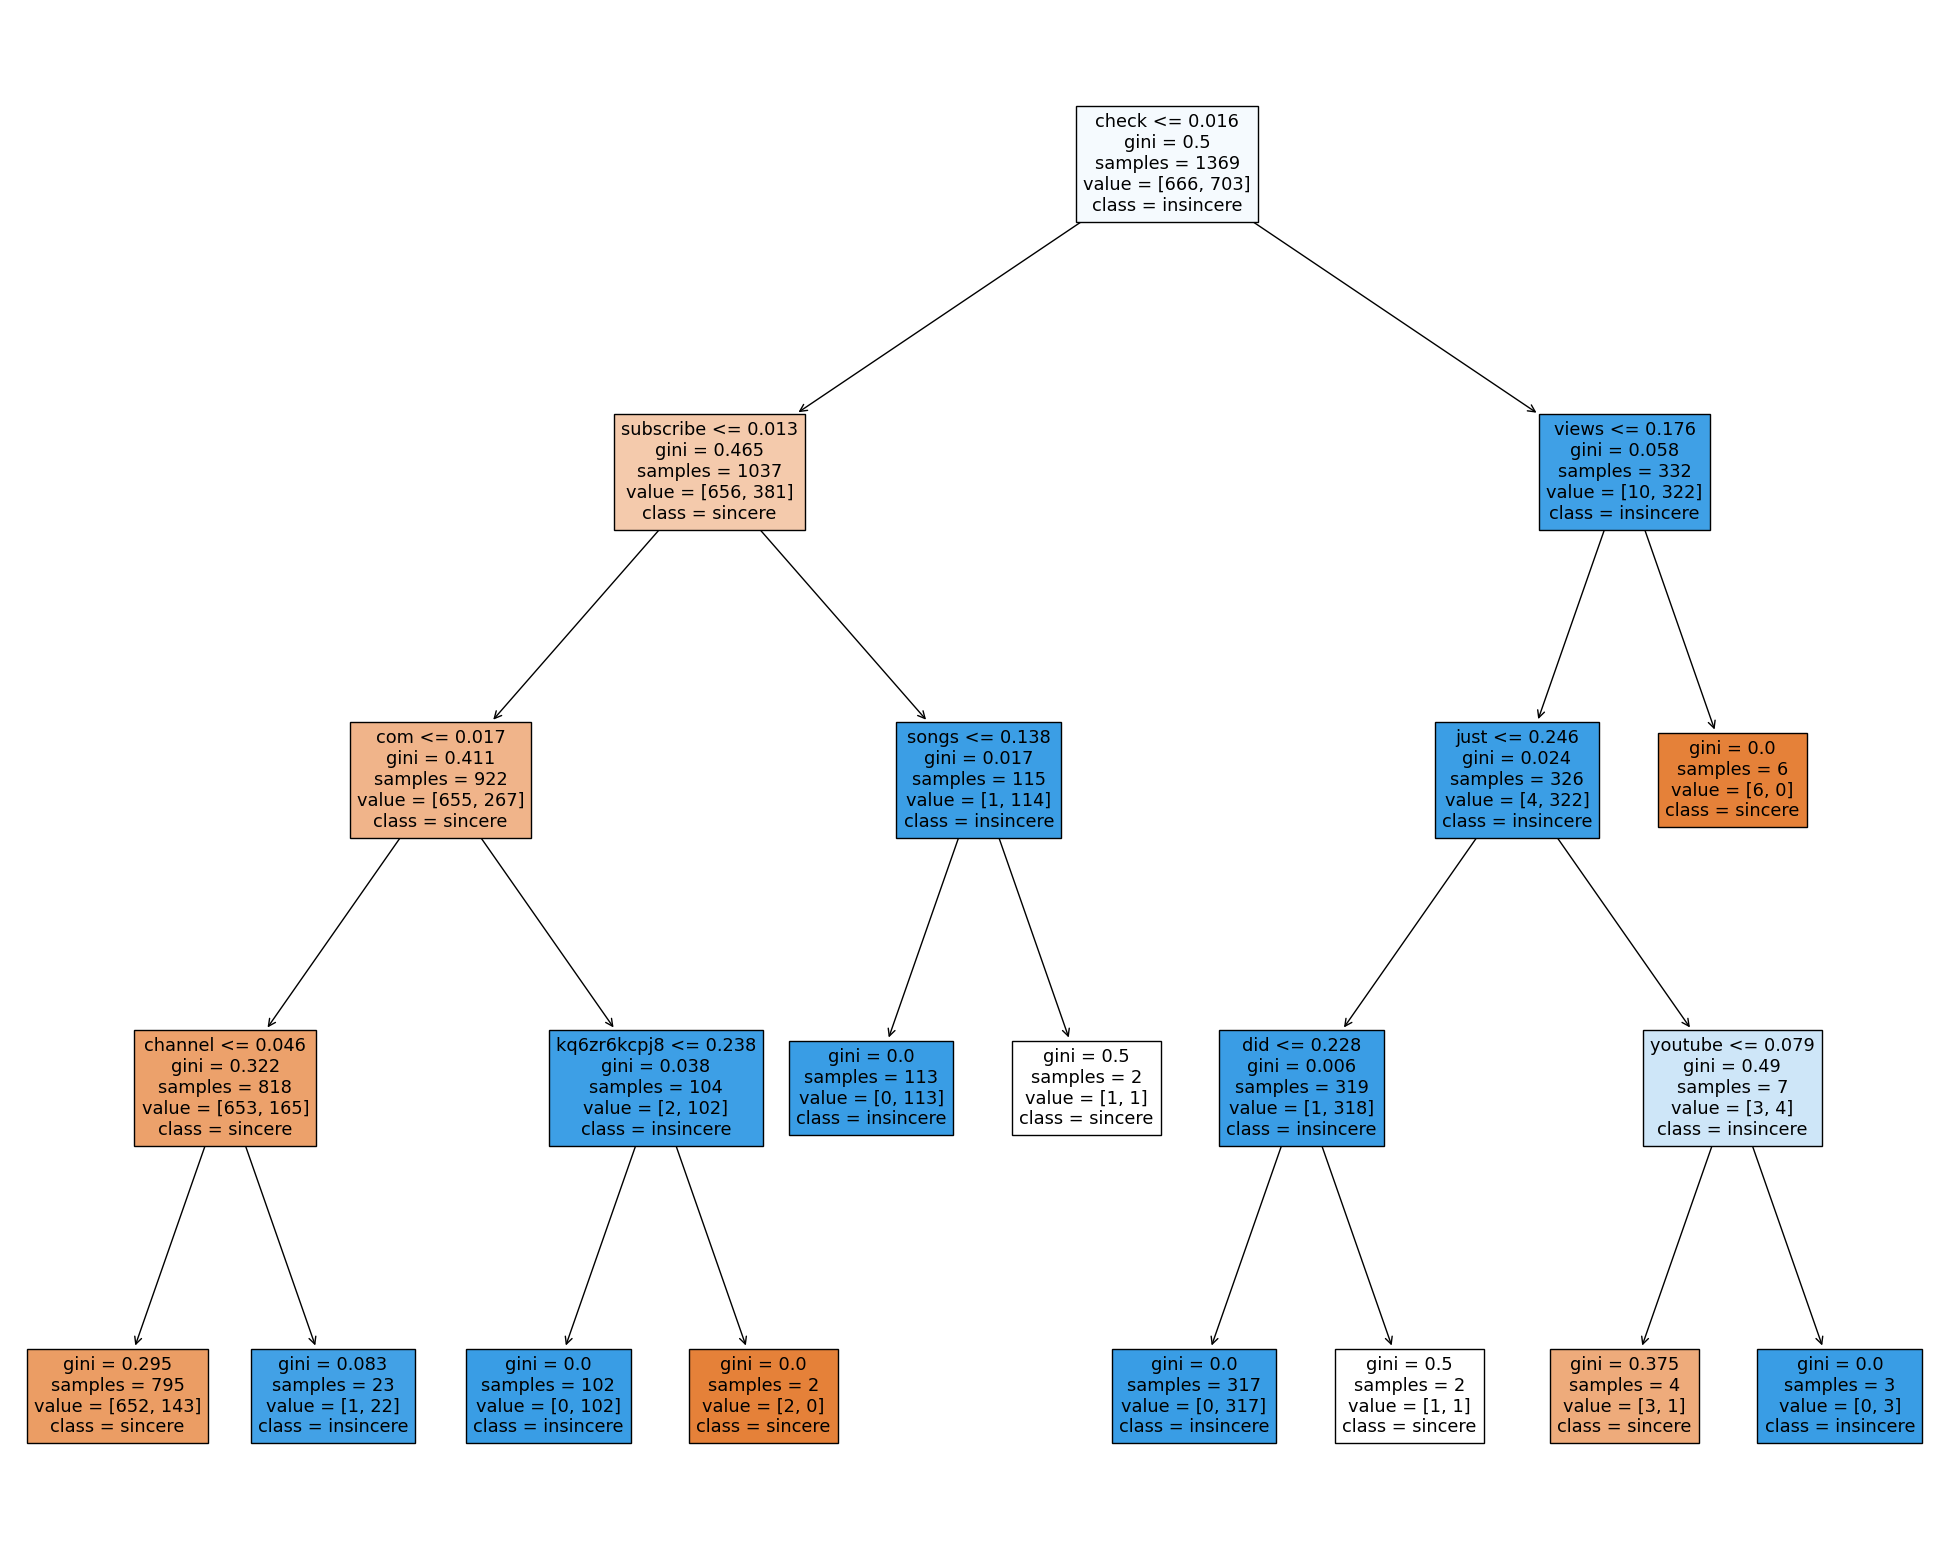

In [18]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dt_clf,
               	feature_names = feature_names,
               	class_names = class_names,
               	filled=True)

## Your turn - Applying this to LingoRank
You can use such models to review some LingoRank predictions

What patterns do you find ?

sources:

* [Interpretable-ml-book](https://christophm.github.io/interpretable-ml-book/lime.html)
* [Explainability 360](https://ai-explainability-360.org/)
* [Datacamp](https://www.datacamp.com/tutorial/explainable-ai-understanding-and-trusting-machine-learning-models)
* [Shap documentation](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)
* [Explaining Text classifier outcomes using LIME](https://towardsdatascience.com/what-makes-your-question-insincere-in-quora-26ee7658b010)
* [Shap example notebooks](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html)
